In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import scipy.stats as st

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.holtwinters import ExponentialSmoothing

plt.rcParams['figure.figsize'] = (10, 8)

In [2]:
data = pd.read_csv('time.txt', parse_dates=[0], dayfirst=True)

In [3]:
data.head(10)

,Time
0,2019-02-10
1,2019-02-10
2,2019-02-12
3,2019-02-12
4,2019-02-13
5,2019-02-14
6,2019-02-15
7,2019-02-16
8,2019-02-16
9,2019-02-17


In [4]:
groups = data['Time'].groupby(data['Time']).count()

In [5]:
data = groups.cumsum()

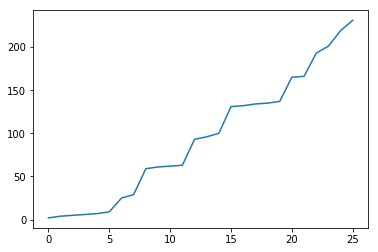

In [6]:
_ = plt.plot(data.values)

STL:

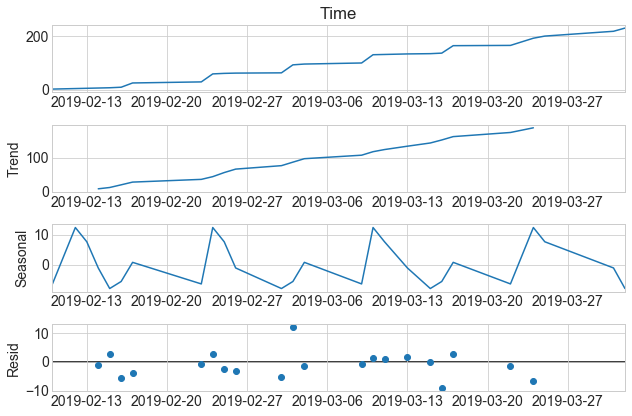

In [12]:
plt.rcParams['figure.figsize'] = (9.0, 6.0)
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 14})
stl_data = seasonal_decompose(data, period=7)
_= stl_data.plot()


# ARIMA

In [13]:
kpss(data, nlags='legacy')

(0.40940321263519297,
 0.07310206351931338,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [14]:
new_data = {}
time_iter = pd.date_range('20190210','20190401',freq='D')
old_data = None
for i in time_iter:
    if i in data:
        new_data[i] = float(data[i])
        old_data = new_data[i] 
    else:
        new_data[i] = old_data

new_data = pd.DataFrame({'Time':new_data})


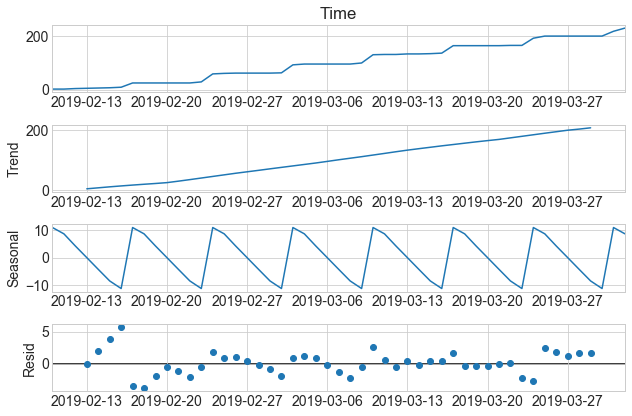

In [15]:
stl_data = seasonal_decompose(new_data['Time'], period=7)
stl_data.plot()

plt.show()

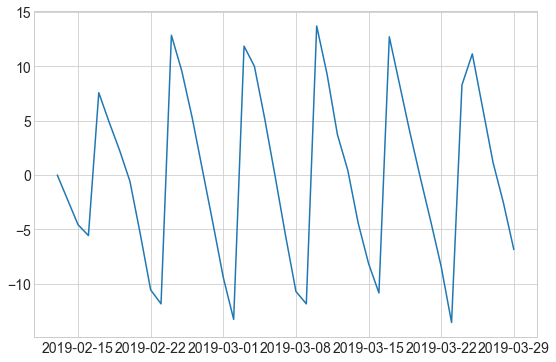

In [16]:
new_data_without_trend = new_data.copy()[3:-3]
new_data_without_trend['Time'] = (new_data['Time'] - stl_data.trend)[3:-3]
plt.plot(new_data_without_trend)

plt.show()

In [17]:
kpss(new_data['Time'], nlags='legacy')

(0.5457819993868097,
 0.03135540554351132,
 11,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [18]:
kpss(new_data_without_trend['Time'], nlags='legacy')

/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.08857810513345855,
 0.1,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

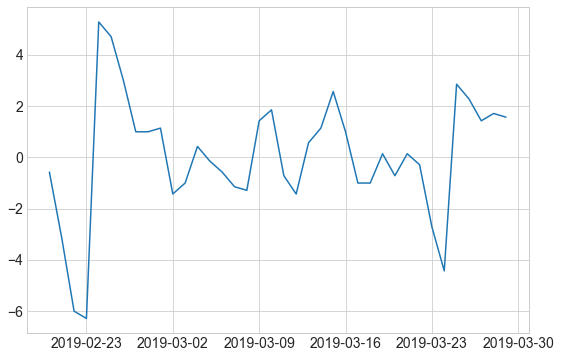

In [19]:
plt.plot(new_data_without_trend.diff(7))

plt.show()

In [20]:
kpss(new_data_without_trend['Time'].diff(7)[7:], nlags='legacy')

/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.22509539267611936,
 0.1,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [21]:
arima = ARIMA(new_data_without_trend['Time'].values, order=(1,1,1)).fit()

arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   44
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -153.003
Method:                       css-mle   S.D. of innovations              7.565
Date:                Tue, 28 Apr 2020   AIC                            314.007
Time:                        09:40:28   BIC                            321.143
Sample:                             1   HQIC                           316.653
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.132      0.041      0.967      -0.253       0.264
ar.L1.D.y      0.3642      0.145      2.519      0.012       0.081       0.648
ma.L1.D.y     -1.0000      0.057    -17.624      0.000      -1.111      -0.889
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.7460           +0.0000j            2.7460            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

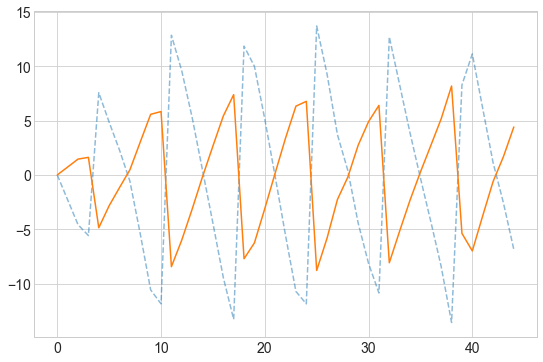

In [22]:
plt.plot(new_data_without_trend['Time'].values, alpha=0.5, ls='--')
plt.plot(arima.predict(1, len(new_data_without_trend), dynamic=False))

plt.show()

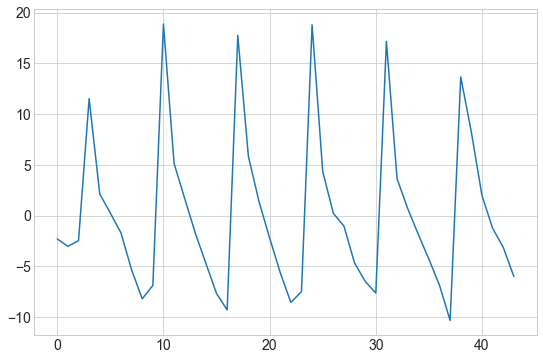

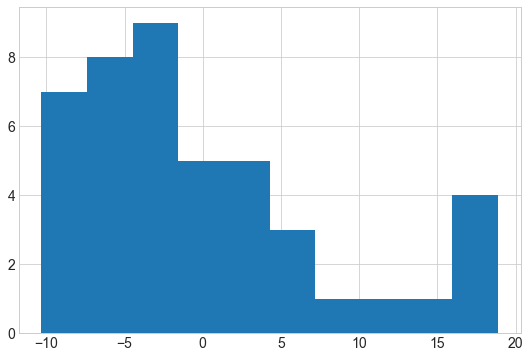

(0.8828225135803223, 0.00033624967909418046)

In [23]:
_ =plt.plot(arima.resid)
plt.show()
_ = plt.hist(arima.resid)
plt.show()
st.shapiro(arima.resid)

In [24]:
arima = SARIMAX(new_data_without_trend['Time'].values, order=(1,0,1), seasonal_order=(0,2,1,7)).fit()

arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   45
Model:             SARIMAX(1, 0, 1)x(0, 2, 1, 7)   Log Likelihood                 -72.834
Date:                           Tue, 28 Apr 2020   AIC                            153.667
Time:                                   09:41:32   BIC                            159.403
Sample:                                        0   HQIC                           155.537
                                            - 45                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1342      0.325      0.414      0.679      -0.502       0.770
ma.L1          0.4605      0.383      1.202      0.229      -0.290       1.211
ma.S.L7       -0.3109      0.316     -0.984      0.325      -0.930       0.309
sigma2         6.2094      1.755      3.538      0.000       2.770       9.649
===================================================================================
Ljung-Box (Q):                       21.74   Jarque-Bera (JB):                 2.20
Prob(Q):                              0.86   Prob(JB):                         0.33
Heteroskedasticity (H):               0.53   Skew:                            -0.28
Prob(H) (two-sided):                  0.33   Kurtosis:                         4.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

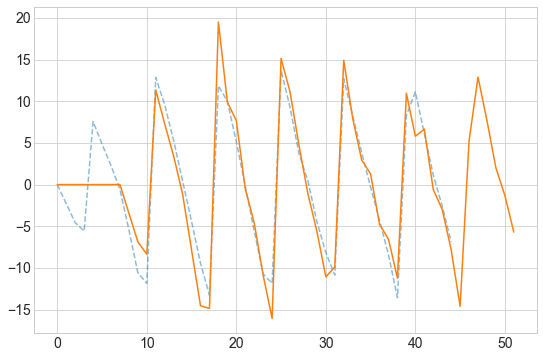

In [25]:
plt.plot(new_data_without_trend['Time'].values, alpha=0.5, ls='--')
plt.plot(arima.predict(0, len(new_data['Time'].values)))

plt.show()

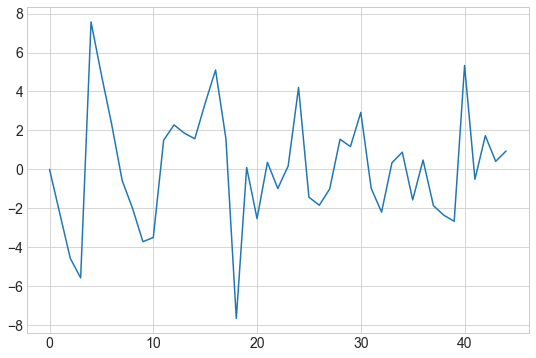

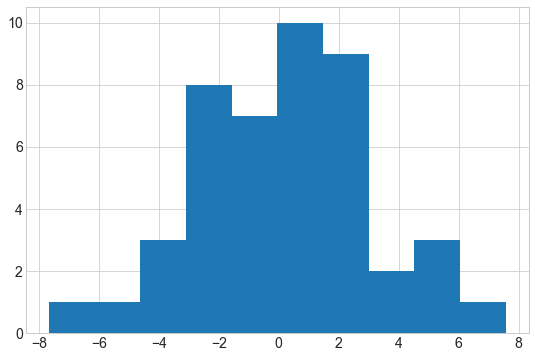

(0.9895407557487488, 0.9533847570419312)

In [26]:
_ =plt.plot(arima.resid)
plt.show()
_ = plt.hist(arima.resid)
plt.show()
st.shapiro(arima.resid)

/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


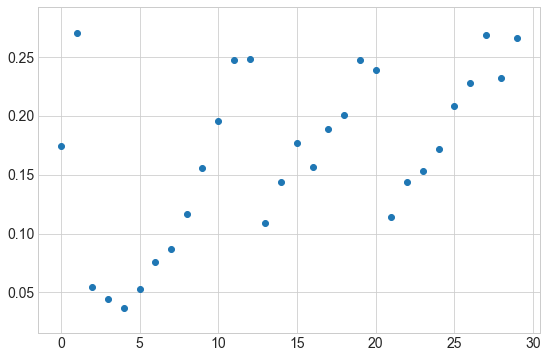

In [27]:
plt.scatter(range(30), acorr_ljungbox(arima.resid, lags=30)[1])

plt.show()

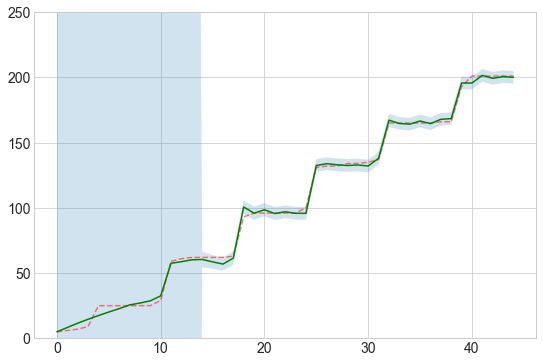

In [28]:
predictition = arima.get_prediction(0, len(new_data_without_trend)-1).conf_int()
intervals = stl_data.trend.values.flatten()[3:-3] + predictition[:, 0], stl_data.trend.values.flatten()[3:-3] + predictition[:, 1]

plt.fill_between(range(len(intervals[0])), intervals[0], intervals[1], alpha=0.2)
plt.ylim(0, 250)
plt.plot(new_data['Time'].values[3:-3], alpha=0.5, ls='--', c='r')
plt.plot(stl_data.trend.values.flatten()[3:-3]+arima.predict(0, len(new_data_without_trend)-1), c='g')

plt.show()

# ETS

/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


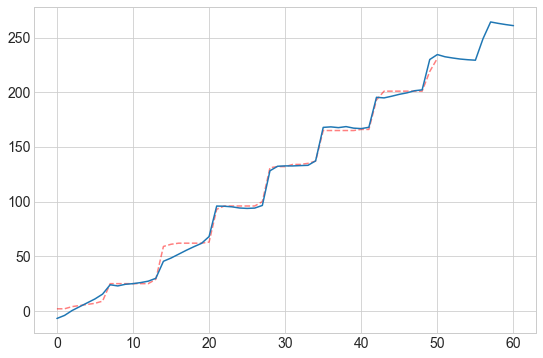

In [29]:
ets = ExponentialSmoothing(new_data['Time'].values, trend='add', seasonal='add', seasonal_periods=7).fit()
plt.plot(new_data['Time'].values, alpha=0.5, ls='--', c='r')
predicted = ets.predict(0, 60)

plt.plot(predicted)

plt.show()